# **4b: Bayesian Inference for Trick Consistency**
Vi modellerar sannolikheten att en åkare lyckas landa ett trick baserat på data från tidigare tävlingar.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import loggamma
from scipy import stats


df = pd.read_parquet("df.parquet.gzip")
df = df.set_index("id")

alfax = pd.read_parquet("alfax.parquet.gzip")
betax = pd.read_parquet("betax.parquet.gzip")
alfay = pd.read_parquet("alfay.parquet.gzip")
betay = pd.read_parquet("betay.parquet.gzip")

**Dataförberedelse**

Vi extraherar information om landade tricks och antal tävlingar.

In [2]:
# Lista över åkare
ids = alfax["id"].to_list()
makes = ["make 1", "make 2", "make 3", "make 4"]
lqc = df.loc[ids, makes]  # Filtrera data för de aktuella åkarna
unique_ids, count_occurrence = np.unique(lqc.index.to_list(), return_counts=True)

comps_competed = pd.DataFrame({
    "id": unique_ids,
    "count": count_occurrence
}).sort_values("id")

**Bayesiansk Modellering**

Vi definierar prior- och posteriorfördelningar för trick-frekvens.

In [3]:
n_tricks = 4

def log_CD_prior(c, d):
    return np.log(0.5**10) - loggamma(10) + (10 - 1) * np.log(c + d + 1) - 0.5 * (c + d + 1) - np.log(c + d)

def log_CD_posterior(c, d, n_comps, df_makes):
    log_p = log_CD_prior(c, d)
    for index, row in df_makes.iterrows():
        x = row.sum()
        log_p += loggamma(c + d) + loggamma(c + x) + loggamma(d + n_tricks - x) - loggamma(c) - loggamma(d) - loggamma(c + d + n_tricks)
    return log_p

**Metropolis-Hastings Algoritm**
Vi estimerar $C_i $ och $ D_i $ för varje åkare med hjälp av en Markov Chain Monte Carlo-metod.

In [4]:
n_samples = 10000
n_skaters = len(ids)
delta = 0.5

Cs = np.zeros((n_samples, n_skaters))
Ds = np.zeros((n_samples, n_skaters))

# Initialisering från Gamma-fördelning
Cs[0] = stats.gamma.rvs(size=n_skaters, a=1, scale=1)
Ds[0] = stats.gamma.rvs(size=n_skaters, a=1, scale=1)

# Metropolis-Hastings
for i in range(n_samples - 1):
    for j in range(n_skaters):
        last_C, last_D = Cs[i, j], Ds[i, j]
        proposal_C = np.exp(np.log(last_C) + delta * stats.norm.rvs())
        proposal_D = np.exp(np.log(last_D) + delta * stats.norm.rvs())

        n_comps = comps_competed.loc[comps_competed["id"] == ids[j], "count"].values[0]
        df_make = lqc.loc[ids[j], :]

        rho = np.exp(log_CD_posterior(proposal_C, proposal_D, n_comps, df_make) - log_CD_posterior(last_C, last_D, n_comps, df_make))
        if stats.uniform.rvs() <= rho:
            Cs[i + 1, j], Ds[i + 1, j] = proposal_C, proposal_D
        else:
            Cs[i + 1, j], Ds[i + 1, j] = last_C, last_D

**Beräkning av $ \theta_i $**
Vi använder de estimerade $ C_i, D_i$ för att simulera sannolikheten att landa ett trick.

In [5]:
sliced_C = Cs[n_samples//2:, :]
sliced_D = Ds[n_samples//2:, :]
thetas = np.random.beta(sliced_C, sliced_D)

**Visualisering av Posteriorfördelningar**
Vi plottar marginalfördelningarna för \( \theta_i, C_i \) och \( D_i \).

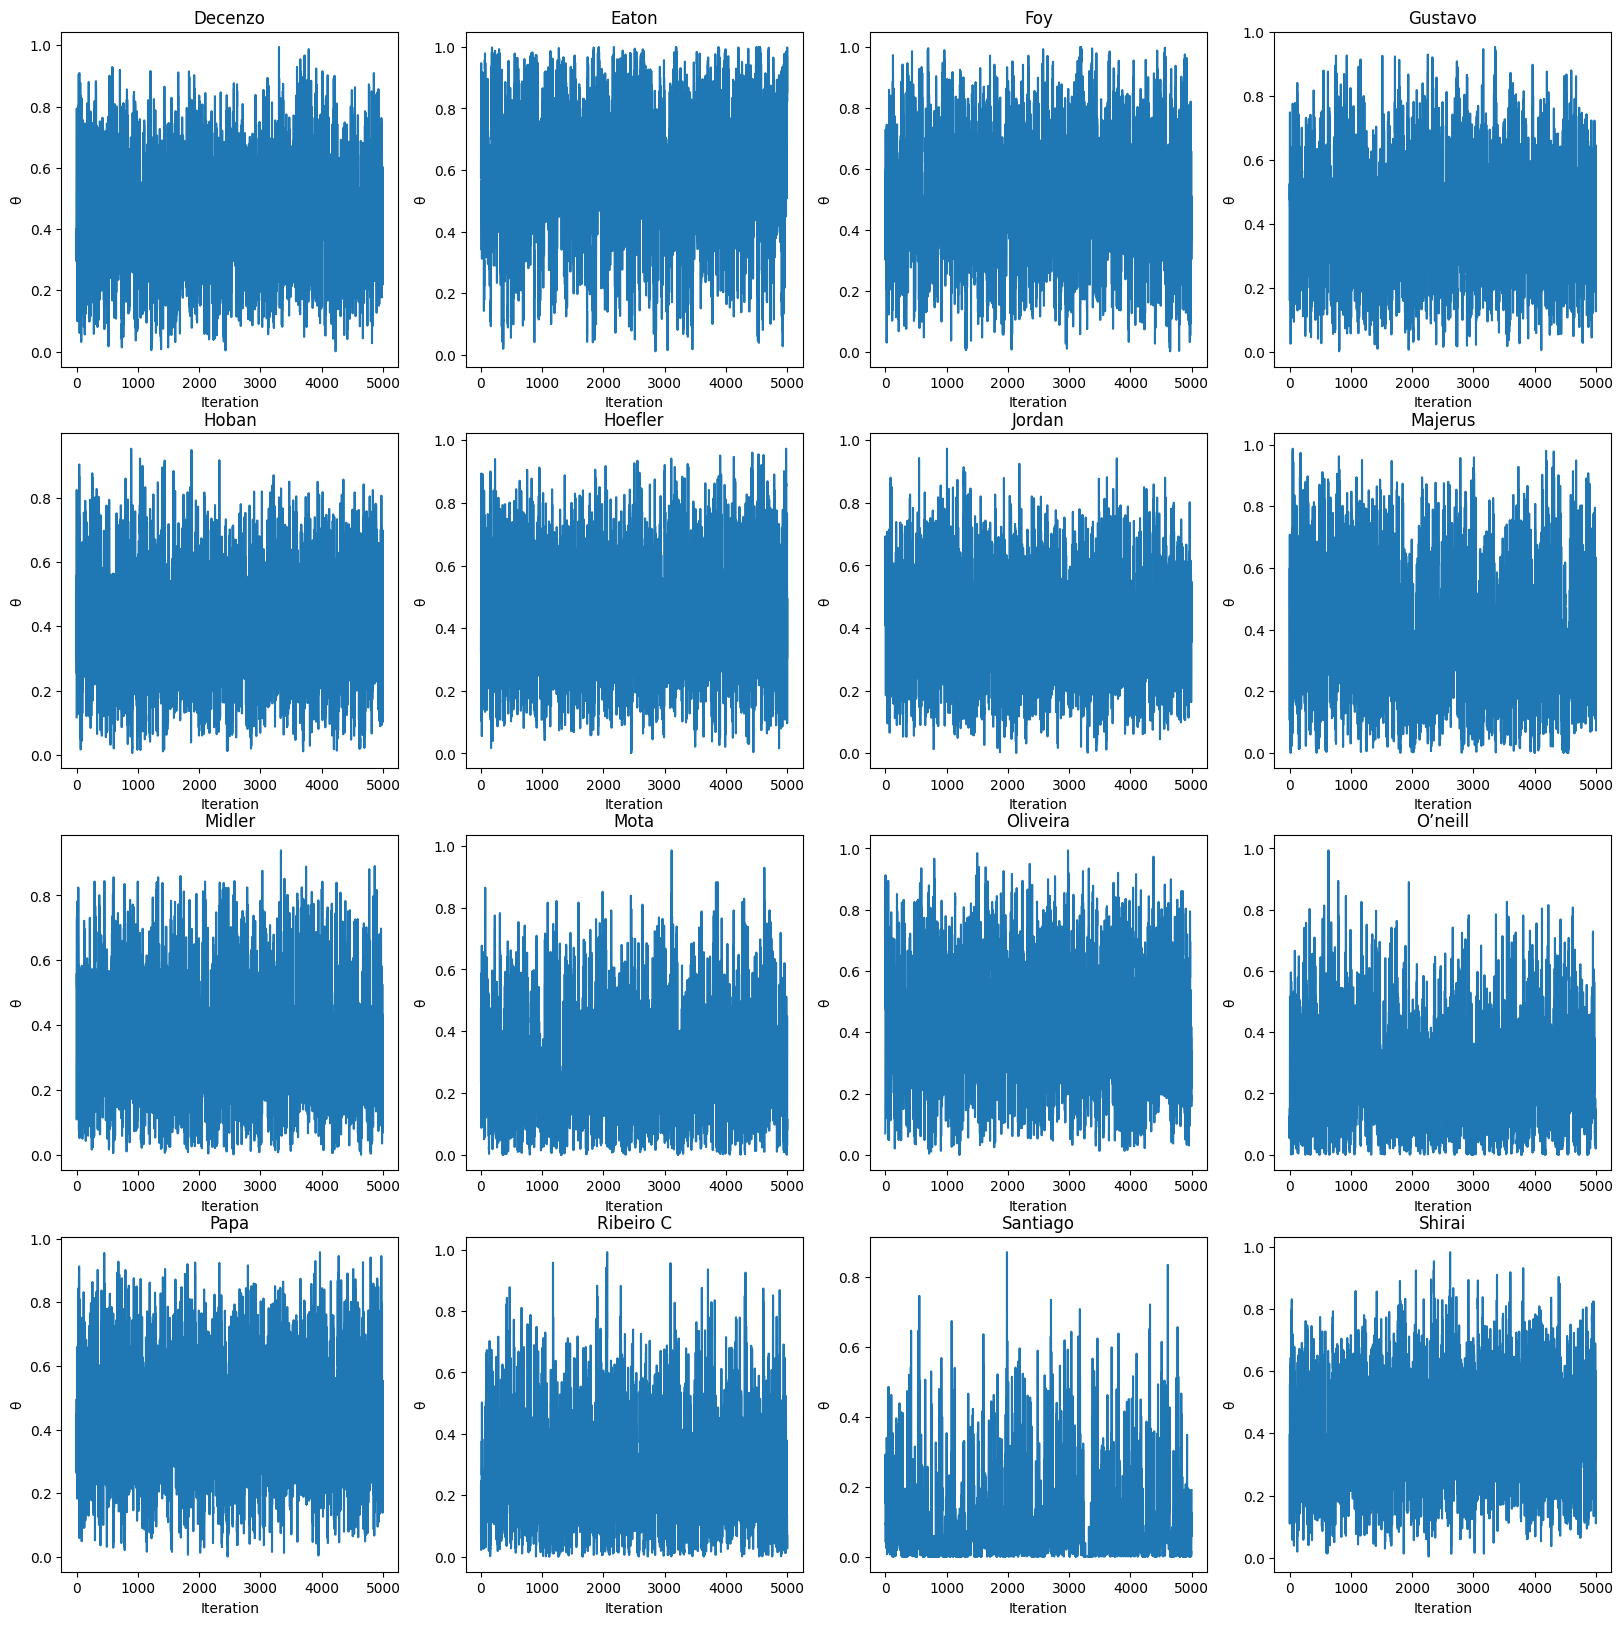

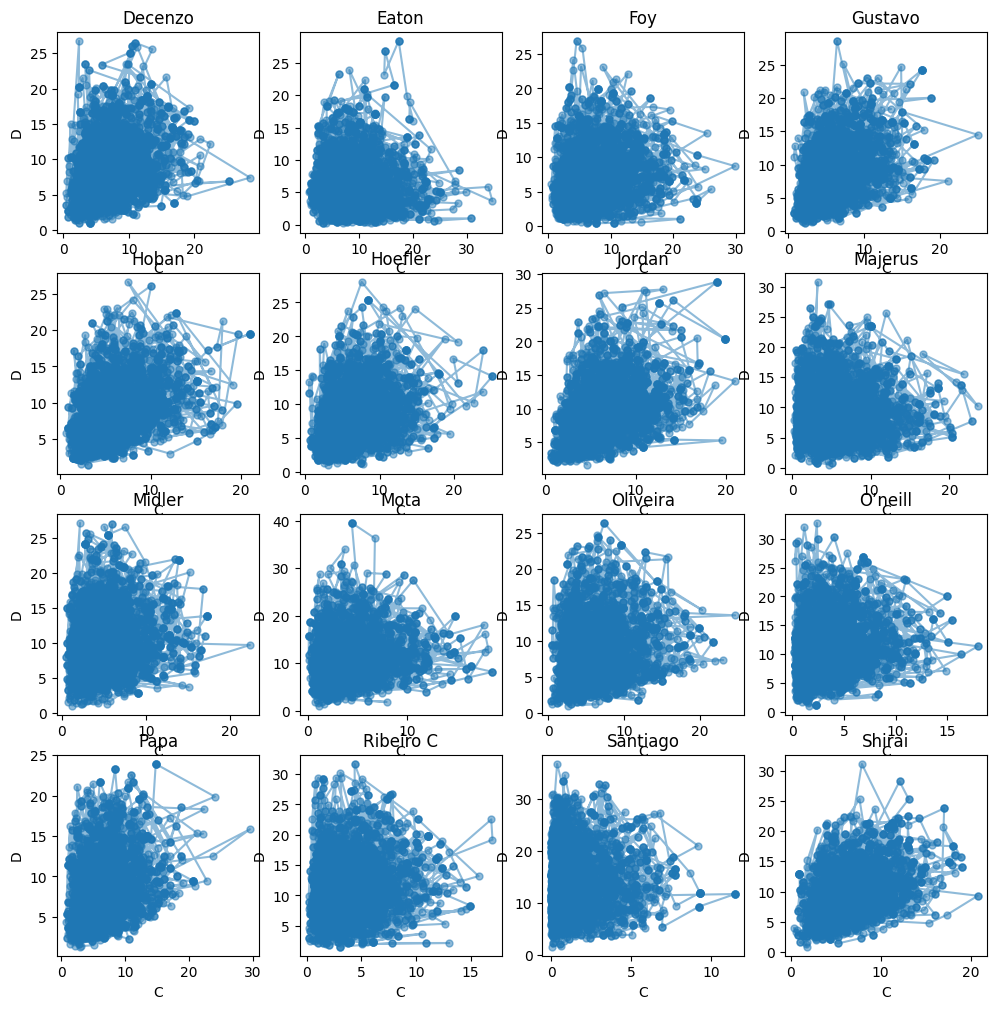

In [6]:
plt.figure(figsize=(20, 20))
for i in range(n_skaters):
    plt.subplot(4, 4, i + 1)
    plt.plot(thetas[:, i])
    plt.xlabel('Iteration')
    plt.ylabel('θ')
    plt.title(ids[i])
plt.show()

plt.figure(figsize=(12, 12))
for j in range(n_skaters):
    plt.subplot(4, 4, j + 1)
    plt.plot(sliced_C[:, j], sliced_D[:, j], '.-', markersize=10, alpha=0.5)
    plt.title(ids[j])
    plt.xlabel('C')
    plt.ylabel('D')
plt.show()

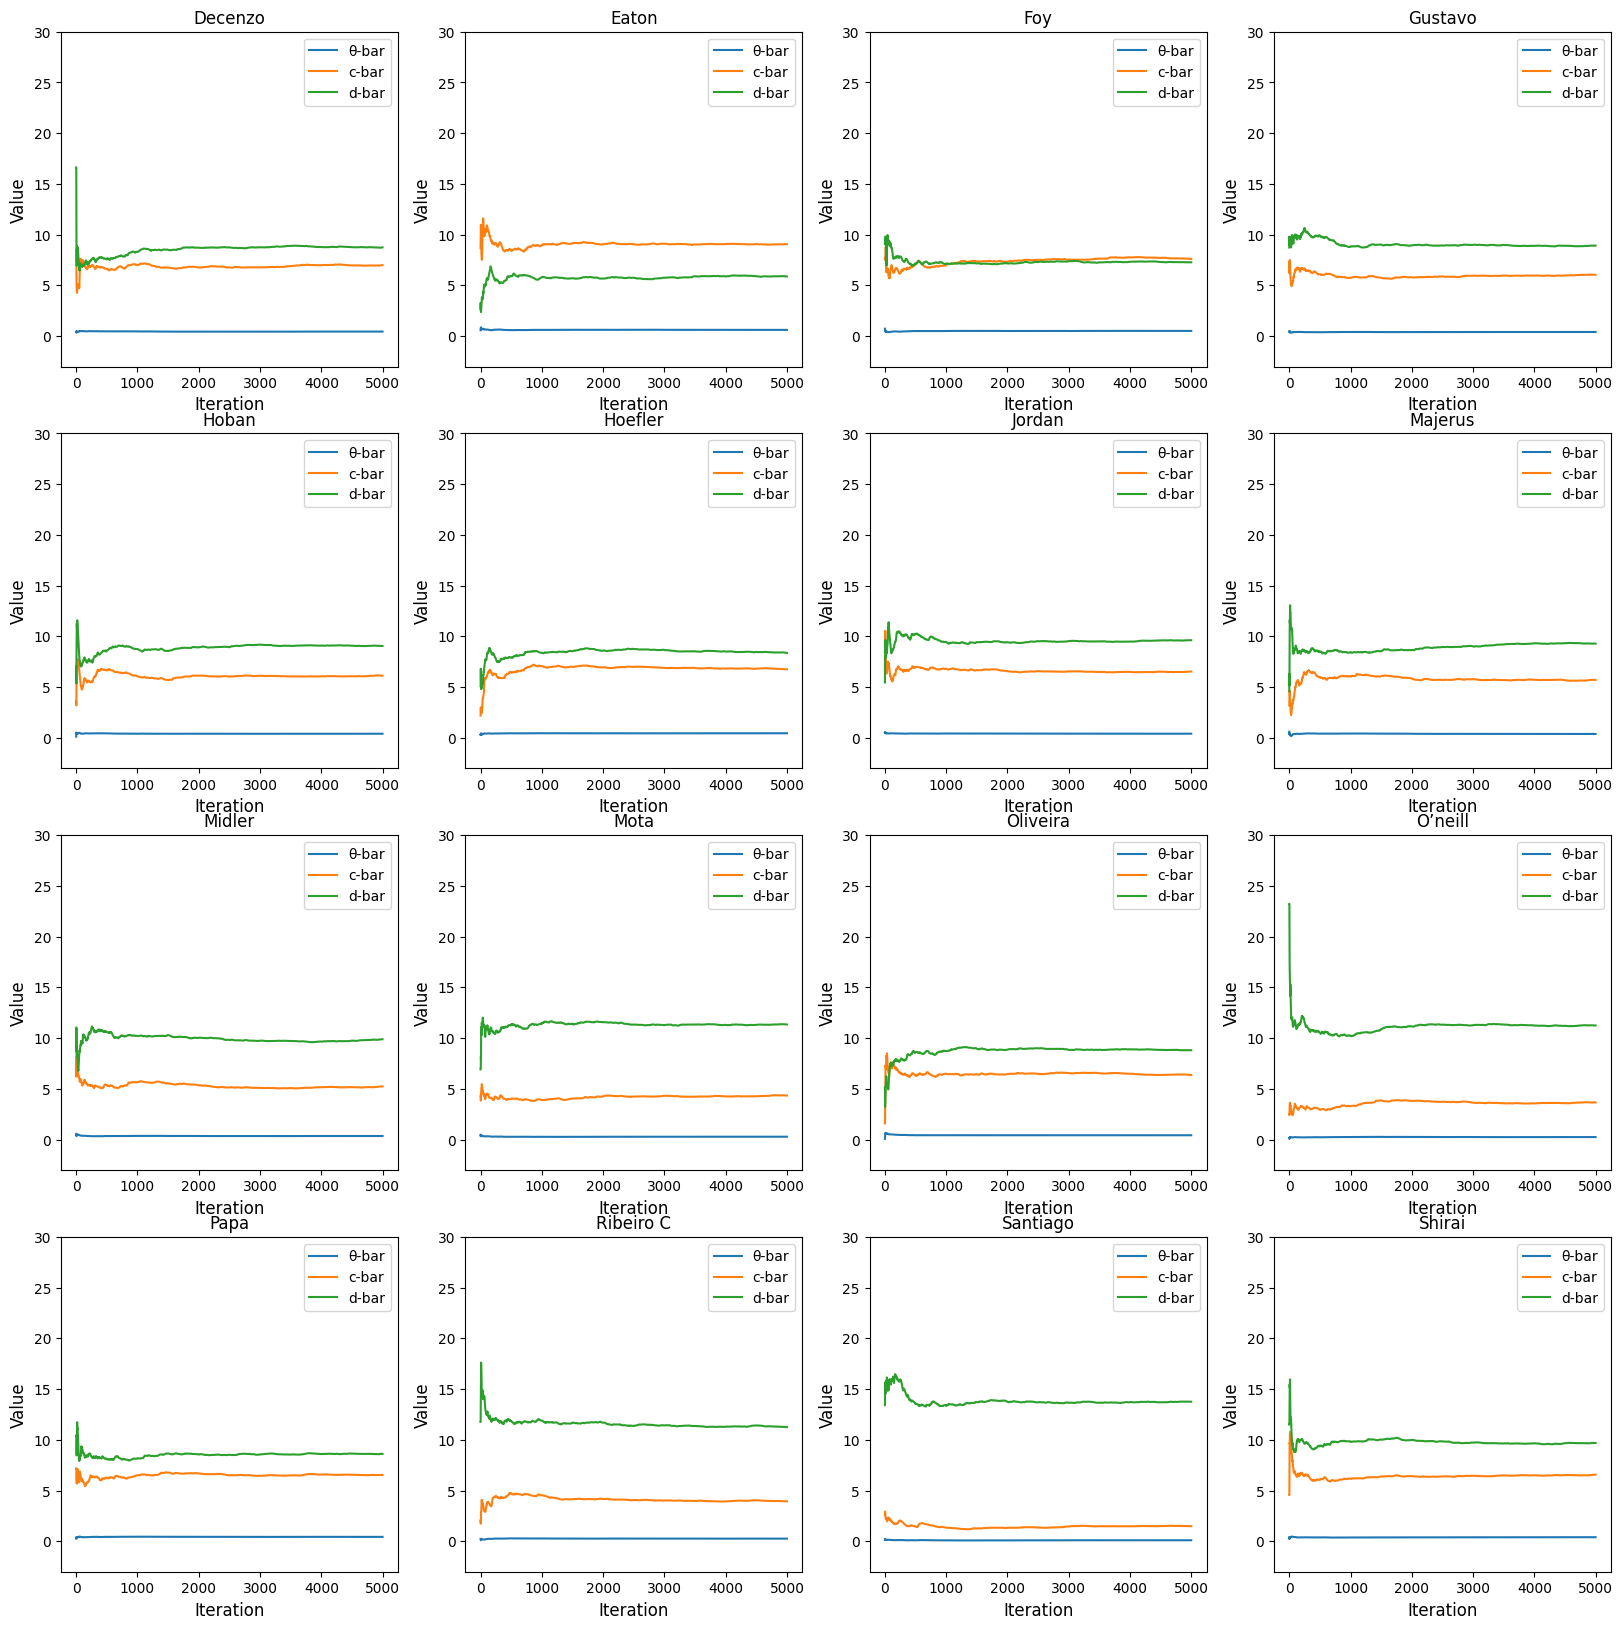

In [7]:
plt.figure(figsize=(20, 20))
for j in range(n_skaters):
    thetas_sample_mean = np.cumsum(thetas[:, j], axis=0) / np.arange(1, n_samples // 2 + 1)
    c_sample_mean = np.cumsum(sliced_C[:, j], axis=0) / np.arange(1, n_samples // 2 + 1)
    d_sample_mean = np.cumsum(sliced_D[:, j], axis=0) / np.arange(1, n_samples // 2 + 1)


    plt.subplot(4, 4, j + 1)
    plt.plot(thetas_sample_mean)
    plt.plot(c_sample_mean)
    plt.plot(d_sample_mean)
    plt.title(ids[j])
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.ylim(-3,30)
    plt.legend(loc="upper right", labels=['θ-bar','c-bar', 'd-bar'])

plt.show()

In [8]:
theta_mean = []
c_mean = []
d_mean = []

for i in range(n_skaters):
    theta_mean.append(np.mean(thetas[:, i]))
    c_mean.append(np.mean(sliced_C[:, i]))
    d_mean.append(np.mean(sliced_D[:, i]))

theta_mean_df = pd.DataFrame({ "id" : ids, 
                                "mean" : theta_mean })

alfa_mean_df = pd.DataFrame({ "id" : ids, 
                                "mean" : c_mean })

beta_mean_df = pd.DataFrame({ "id" : ids, 
                                "mean" : d_mean })


theta_var = []
c_var = []
d_var = []

for i in range(n_skaters):
    theta_var.append(np.var(thetas[:, i]))
    c_var.append(np.var(sliced_C[:, i]))
    d_var.append(np.var(sliced_D[:, i]))

theta_var_df = pd.DataFrame({ "id" : ids, 
                                "variance" : theta_var })

c_var_df = pd.DataFrame({ "id" : ids, 
                                "variance" : c_var })

d_var_df = pd.DataFrame({ "id" : ids, 
                                "variance" : d_var })

alla = pd.DataFrame({ "id" : ids, "theta mean" : theta_mean, "theta var" : theta_var, "alpha mean" : c_mean, "alpha var" : c_var, "beta mean" : d_mean, "beta var" : d_var })
alla.round(2).to_csv('alla4.csv', index=False)

# **4c**
**Simulering av 5000 LCQ-tävlingar**
Vi simulerar resultat baserat på de estimerade sannolikheterna.

In [9]:
from collections import Counter

total_grades = pd.DataFrame({
    "id": ids,
    "total_grade" : None
})

nested_finalists = []
np.random.seed(42)  # För reproducerbara resultat

for i in range(n_samples // 2):
    total_grades = []
    
    for j in range(n_skaters):
        V = np.random.binomial(1, thetas[i, j], 4)
        Z = np.random.beta(alfax.loc[alfax["id"] == ids[j], "alfa"].values[0], 
                           betax.loc[betax["id"] == ids[j], "beta"].values[0], 4)
        tricks = V * Z
        runs = np.random.beta(alfay.loc[alfay["id"] == ids[j], "alfa"].values[0], 
                              betay.loc[betay["id"] == ids[j], "beta"].values[0], 2)

        max1_trick = tricks.max()
        tricks = np.delete(tricks, np.argmax(tricks))
        max2_trick = tricks.max()
        max_runs = runs.max()

        total_grade = max1_trick + max2_trick + max_runs
        total_grades.append((ids[j], total_grade))

    total_grades = sorted(total_grades, key=lambda x: x[1], reverse=True)
    nested_finalists.append([x[0] for x in total_grades[:4]])

# Hitta de vanligaste finalisterna
finalists_flat = [skater for sublist in nested_finalists for skater in sublist]
most_common_finalists = Counter(finalists_flat).most_common(4)

print("Most common finalists:", most_common_finalists)

Most common finalists: [('Jordan', 2426), ('Shirai', 2246), ('Hoban', 2139), ('Eaton', 2124)]


**Utvärdering av Modellens Förutsägelser**
Vi beräknar andelen av korrekta förutsägelser av modellen (med korrekt menas den exakta kombinationen av 4 finalister)

In [10]:
real_finalists = {"Gustavo", "Hoban", "Eaton", "Decenzo"}
sim_finalists = {"Hoban", "Eaton", "Jordan", "Shirai"}

def count_correct_finalists(target_finalists):
    return sum(1 for sublist in nested_finalists if set(sublist) == target_finalists)

prop_real_finalists = count_correct_finalists(real_finalists) / (n_samples // 2)

print(f"Proportion of real finalists appearing: {prop_real_finalists:.2%}")

Proportion of real finalists appearing: 0.26%
